In [27]:
import networkx as nx
import numpy as np
from docplex.mp.model import Model

from qiskit.utils import algorithm_globals
from qiskit_optimization.algorithms import OptimizationResult
from qiskit_optimization.exceptions import QiskitOptimizationError
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp

# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx


from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [28]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

In [29]:
def create_random_instance(n: int, low: int = 0, high: int = 100, seed: int = None) -> "Tsp":
    """Create a random instance of the traveling salesman problem
    Args:
        n: the number of nodes.
        low: The minimum value for the coordinate of a node.
        high: The maximum value for the coordinate of a node.
        seed: the seed for the random coordinates.
    Returns:
            A Tsp instance created from the input information
    """
    if seed:
        algorithm_globals.random_seed = seed
    coord = algorithm_globals.random.uniform(low, high, (n, 2))
    pos = {i: (coord_[0], coord_[1]) for i, coord_ in enumerate(coord)}
    graph = nx.random_geometric_graph(n, np.hypot(high - low, high - low) + 1, pos=pos)
    for w, v in graph.edges:
        delta = [graph.nodes[w]["pos"][i] - graph.nodes[v]["pos"][i] for i in range(2)]
        graph.edges[w, v]["weight"] = np.rint(np.hypot(delta[0], delta[1]))
    return Tsp(graph)

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


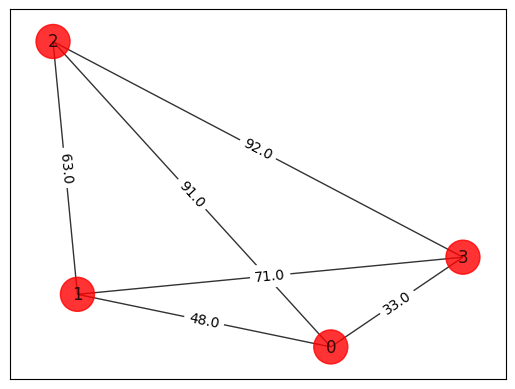

In [39]:
# Generating a graph of 3 nodes
distances= [[0, 45, 20, 5], [45, 0, 35, 25], [20, 30, 0, 30], [5, 25, 30, 0]]
n = 4
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

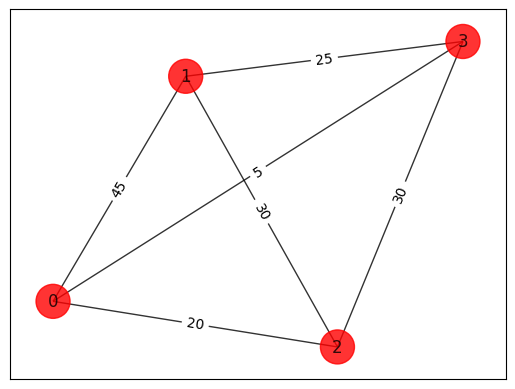

In [43]:
A = np.array([[0, 45, 20, 5], [45, 0, 35, 25], [20, 30, 0, 30], [5, 25, 30, 0]])
G = nx.from_numpy_array(A)
colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)


In [44]:
tsp = Tsp(G)

order = (0, 1, 2, 3) Distance = 236.0
Best order from brute force = (0, 1, 2, 3) with total distance = 236.0


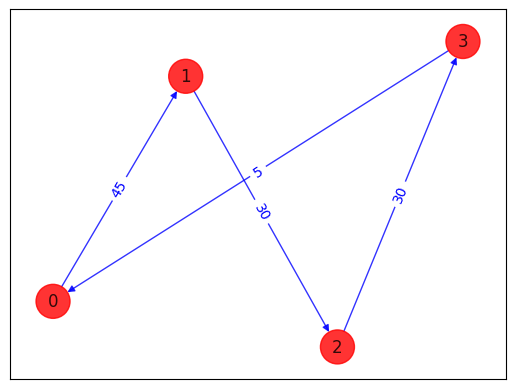

In [45]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)

draw_tsp_solution(tsp.graph, best_order, colors, pos)

In [46]:
qp = tsp.to_quadratic_program()
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 20166.0
Ising Hamiltonian:
-2517.0 * IIIIIIIIIIIIIIIZ
- 2517.0 * IIIIIIIIIIIIIIZI
- 2517.0 * IIIIIIIIIIIIIZII
- 2517.0 * IIIIIIIIIIIIZIII
- 2532.0 * IIIIIIIIIIIZIIII
- 2532.0 * IIIIIIIIIIZIIIII
- 2532.0 * IIIIIIIIIZIIIIII
- 2532.0 * IIIIIIIIZIIIIIII
- 2522.0 * IIIIIIIZIIIIIIII
- 2522.0 * IIIIIIZIIIIIIIII
- 2522.0 * IIIIIZIIIIIIIIII
- 2522.0 * IIIIZIIIIIIIIIII
- 2512.0 * IIIZIIIIIIIIIIII
- 2512.0 * IIZIIIIIIIIIIIII
- 2512.0 * IZIIIIIIIIIIIIII
- 2512.0 * ZIIIIIIIIIIIIIII
+ 620.5 * IIIIIIIIIIIIIIZZ
+ 620.5 * IIIIIIIIIIIIIZIZ
+ 620.5 * IIIIIIIIIIIIIZZI
+ 620.5 * IIIIIIIIIIIIZIIZ
+ 620.5 * IIIIIIIIIIIIZIZI
+ 620.5 * IIIIIIIIIIIIZZII
+ 620.5 * IIIIIIIIIIIZIIIZ
+ 11.25 * IIIIIIIIIIIZIIZI
+ 11.25 * IIIIIIIIIIIZZIII
+ 11.25 * IIIIIIIIIIZIIIIZ
+ 620.5 * IIIIIIIIIIZIIIZI
+ 11.25 * IIIIIIIIIIZIIZII
+ 620.5 * IIIIIIIIIIZZIIII
+ 11.25 * IIIIIIIIIZIIIIZI
+ 620.5 * IIIIIIIIIZIIIZII
+ 11.25 * IIIIIIIIIZIIZIII
+ 620.5 * IIIIIIIIIZIZIIII
+ 620.5 * IIIIIIIIIZZIIIII
+ 11.25 * IIIIIIIIZIIIIIIZ
+ 11.

In [47]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 80.0
variable values: x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_0=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, x_3_0=0.0, x_3_1=0.0, x_3_2=1.0, x_3_3=0.0
status: SUCCESS


In [48]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.tools.visualization import plot_histogram
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,execute, Aer

In [51]:
def create_cost_Hamiltonian(distances):
    n_cities = len(distances)
    H = np.zeros((n_cities, n_cities))
    for i in range(n_cities):
        for j in range(n_cities):
            if i != j:
                H[i][j] = distances[i][j]
    return H

def create_mixer_Hamiltonian(n_cities):
    H = np.ones((n_cities, n_cities)) - np.eye(n_cities)
    return H

def create_QAOA_circuit(distances, p):
    n_cities = len(distances)
    
    qr = QuantumRegister(n_cities)
    cr = ClassicalRegister(n_cities)
    
    # Create quantum circuit
    qc = QuantumCircuit(qr, cr)
    
    # Create cost and mixer Hamiltonians
    cost_H = create_cost_Hamiltonian(distances)
    mixer_H = create_mixer_Hamiltonian(n_cities)
    
    # Apply QAOA steps
    for i in range(p):
        # Apply cost Hamiltonian
        for j in range(n_cities):
            for k in range(j+1, n_cities):
                qc.cx(qr[j], qr[k])
                qc.p(-cost_H[j][k], qr[k])
                qc.cx(qr[j], qr[k])
        # Apply mixer Hamiltonian
        for j in range(n_cities):
            qc.h(qr[j])
            qc.x(qr[j])
        qc.barrier()
        for j in range(n_cities):
            for k in range(j+1, n_cities):
                qc.cx(qr[j], qr[k])
                qc.p(-mixer_H[j][k], qr[k])
                qc.cx(qr[j], qr[k])
        for j in range(n_cities):
            qc.x(qr[j])
            qc.h(qr[j])
    
    # Measure qubits
    for j in range(n_cities):
        qc.measure(qr[j], cr[j])
    
    
    return qc

In [52]:
adj_matrix = nx.to_numpy_array(tsp.graph)
cv = create_QAOA_circuit(adj_matrix, 200)

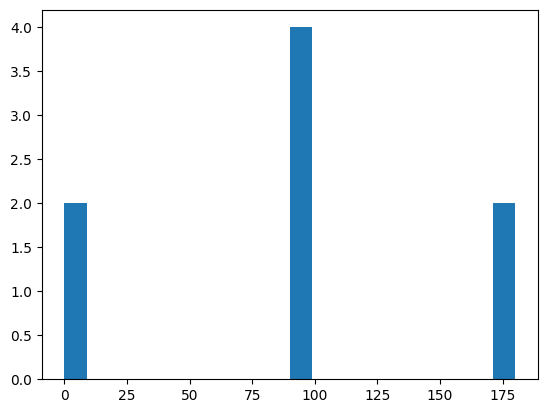

[90, 0, 0, 180, 90, 90, 90, 180]


In [62]:
# Execute the circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')
result = execute(cv, backend , shots=2047).result()

# Extract the results from the execution object
counts = result.get_counts()

# Initialize the list of optimal costs
optimal_costs = []

# Iterate over the results
for bitstring, count in counts.items():
    # Convert the bitstring to a list of integers
    path = [int(x) for x in bitstring]
    
    # Compute the cost of the path
    cost = 0
    for i in range(len(path)-1):
        cost += distances[path[i]][path[i+1]]
    cost += distances[path[-1]][path[0]]
    
    # Append the cost to the list
    optimal_costs.append(cost)

# Plot the histogram of optimal costs
plt.hist(optimal_costs, bins=20)
plt.show()
print(optimal_costs)